<a href="https://colab.research.google.com/github/sbc806/cpsc_533y_project/blob/master/run_nlgat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!git clone https://github.com/sbc806/cpsc_533y_project.git

Cloning into 'cpsc_533y_project'...
remote: Enumerating objects: 46, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 46 (delta 14), reused 16 (delta 4), pack-reused 10
Receiving objects: 100% (46/46), 275.82 KiB | 8.11 MiB/s, done.
Resolving deltas: 100% (14/14), done.


In [4]:
import sys as sys

sys.path.append("/content/cpsc_533y_project")

Read in data

In [5]:
!pip install open3d

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 420.5/420.5 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 87.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 91.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 82.0 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.6
    Uninstalling widgetsnbextension-3.6.6:
      Successfully uninstalled widgetsnbextension-3.6.6
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1
  Attempting uninstall: nbformat
    Found existing installation: nbformat 5.9.2
    Uninstalling nbformat-5.9.2:
      Successfully uninstalled nb

# Get configuration

In [6]:
!pip install ml_collections==0.1.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ml_collections: filename=ml_collections-0.1.1-py3-none-any.whl size=94505 sha256=f57266e1b83f60146f35ccf6f5efc5e9b2c8595692cbc5634f00d3b39a06e29f
  Stored in directory: /root/.cache/pip/wheels/7b/89/c9/a9b87790789e94aadcfc393c283e3ecd5ab916aed0a31be8fe
Successfully built ml_collections


In [7]:
import ml_collections

In [8]:
def get_config():
    config = ml_collections.ConfigDict()

    config.mode = "train"

    # Hyperparameters for dataset.
    config.num_pts = 64
    config.num_classes = 40
    config.use_voxel = False
    config.rot_type = "SO3"
    config.rot = False
    config.normalize = True
    config.center = False
    config.preprocess = False

    # Hyperparameters for models.

    # Hyperparameters for GSN
    config.gsn_init = None

    # Hyperparameters for GRN
    # Localize each local Gram matrix
    config.localize = True
    # For sorting the rows of the Gram matrix
    # Can sort rows in ascending or descending order
    config.descending = False
    # For converting MxMxN tensor to MxN tensor
    # Can be average, absolute_average or maximum
    config.reduce_option = "average"

    # Hyperparameters for training.
    config.log_dir = "logs"
    config.use_cuda = True
    config.batch_size = 32
    config.num_epochs = 200
    config.lr = 0.02
    config.weight_decay = 0.0
    config.label_smoothing = 0.20

    # Hyperparameters for ablation study
    config.mode = "both"
    return config

In [9]:
config = get_config()

In [10]:
config

batch_size: 32
center: false
descending: false
gsn_init: null
label_smoothing: 0.2
localize: true
log_dir: logs
lr: 0.02
mode: both
normalize: true
num_classes: 40
num_epochs: 200
num_pts: 64
preprocess: false
reduce_option: average
rot: false
rot_type: SO3
use_cuda: true
use_voxel: false
weight_decay: 0.0

# Get dataloaders

In [11]:
# From ScanObjectNN GitHub
def normalize_data(pcs):
    for pc in pcs:
        d = max(np.sum(np.abs(pc)**2, axis=-1)**(1./2))
        # print(d)
        pc /= d
    return pcs

In [12]:
# From ScanObjectNN GitHub
def center_data(pcs):
    for pc in pcs:
        centroid = np.mean(pc, axis=0)
        pc[:0]-=centroid[0]
        pc[:,1]-=centroid[1]
        pc[:,2]-=centroid[2]
        # print(centroid)
    return pcs

In [13]:
from torch.utils.data import Subset
import torch
import torch.nn as nn
import torch.utils.data
import torch.optim as optim
import torch.nn.functional as F

import time
import numpy as np

In [14]:
# Make any adjustments to the data configuration
config.num_pts=256

In [15]:
config.rot=True

## ModelNet40

## Copy data from original directory to /cpsc_533y_project/data

In [16]:
!cp -r /content/drive/MyDrive/cpsc_533y/project_datasets/modelnet40_ply_hdf5_2048 /content/cpsc_533y_project/data

In [17]:
from dataloader import load_data, ModelNetDataLoader

print(config)

# Adjust path to the folder modelnet40_ply_hdf5_2048 as needed
datapath = "/content/cpsc_533y_project/data/modelnet40_ply_hdf5_2048/"
n_points = config.num_pts
use_voxel = config.use_voxel
rot_type = config.rot_type
rot = config.rot

train_data, train_label, test_data, test_label = load_data(datapath, classification=True)
if config.normalize:
    print("Normalizing training data")
    train_data = normalize_data(train_data)
if config.center:
    print("Centering training data")
    train_data = center_data(train_data)
if config.normalize:
    print("Normalizing test data")
    test_data = normalize_data(test_data)
if config.center:
    print("Centering test data")
    test_data = center_data(test_data)
trainDataset = ModelNetDataLoader(train_data, train_label, use_voxel=use_voxel, point_num = n_points, rot_type=rot_type,rot=rot)
testDataset = ModelNetDataLoader(test_data, test_label, use_voxel=use_voxel, point_num = n_points, rot_type=rot_type,rot=rot)
trainDataLoader = torch.utils.data.DataLoader(trainDataset, batch_size=config.batch_size, shuffle=True) #, num_workers = 6
testDataLoader = torch.utils.data.DataLoader(testDataset, batch_size=config.batch_size, shuffle=False) #, num_workers = 6

# Create a single batch to overfit on
num_all=4
weights = torch.ones(len(trainDataset))
random_indices=torch.multinomial(weights,num_all,replacement=False)
batch_subset = Subset(trainDataset, random_indices)
batchTrainDataLoader=torch.utils.data.DataLoader(batch_subset,batch_size=4,shuffle=True)
batchTestDataLoader=torch.utils.data.DataLoader(batch_subset,batch_size=4,shuffle=False)

batch_size: 32
center: false
descending: false
gsn_init: null
label_smoothing: 0.2
localize: true
log_dir: logs
lr: 0.02
mode: both
normalize: true
num_classes: 40
num_epochs: 200
num_pts: 256
preprocess: false
reduce_option: average
rot: true
rot_type: SO3
use_cuda: true
use_voxel: false
weight_decay: 0.0

Normalizing training data
Normalizing test data


In [18]:
print(len(trainDataset[0]))

3


In [19]:
data = next(iter(trainDataLoader))
# First element is the point cloud, second element is the estimated normals, third element is the labels
# If use_voxel=True, third element will be the voxels, and fourth element will be the labels
print(len(data))

3


In [20]:
pc = data[0]
print(f"Point cloud batch shape: {pc.shape}")

Point cloud batch shape: torch.Size([32, 256, 3])


In [21]:
for i in range(0, 2):
    data_2 = next(iter(trainDataLoader))
pc_2 = data_2[0]

In [22]:
for i in range(0, 3):
    data_3 = next(iter(trainDataLoader))
pc_3 = data_3[0]

## ScanObjectNN

In [ ]:
import shutil as shutil

shutil.copy("/content/drive/MyDrive/cpsc_533y/project_datasets/h5_files/main_split_nobg/test_objectdataset_augmentedrot_scale75.h5",
            "/content/cpsc_533y_project/data/ScanObjectNN_nobg")

shutil.copy("/content/drive/MyDrive/cpsc_533y/project_datasets/h5_files/main_split_nobg/training_objectdataset_augmentedrot_scale75.h5",
            "/content/cpsc_533y_project/data/ScanObjectNN_nobg")

'/content/cpsc_533y_project/data/ScanObjectNN_nobg/training_objectdataset_augmentedrot_scale75.h5'

In [ ]:
from dataloader import load_h5_scanobjectNN, ScanObjectNNDataLoader

batch_size = 32
rot = False
rot_type = "SO3"
h5_train = "/content/cpsc_533y_project/data/ScanObjectNN_nobg/training_objectdataset_augmentedrot_scale75.h5"
h5_test = "/content/cpsc_533y_project/data/ScanObjectNN_nobg/test_objectdataset_augmentedrot_scale75.h5"
n_points = 16

train_data, train_label, test_data, test_label = load_h5_scanobjectNN(h5_train, h5_test)
trainDataset = ScanObjectNNDataLoader(train_data, train_label,n_points=n_points, rot=rot, rot_type=rot_type)
testDataset = ScanObjectNNDataLoader(test_data, test_label,n_points=n_points, rot=rot, rot_type=rot_type)
trainDataLoader = torch.utils.data.DataLoader(trainDataset, batch_size=batch_size, shuffle=True) #, num_workers = 6
testDataLoader = torch.utils.data.DataLoader(testDataset, batch_size=batch_size, shuffle=False) #, num_workers = 6

In [ ]:
data = next(iter(testDataLoader))
# First element is the point cloud, second element is the estimated normals, third element is the labels
# If use_voxel=True, third elment will be the voxels, and fourth element will be the labels
print(len(data))

3


In [ ]:
data[0][0].shape

torch.Size([64, 3])

In [ ]:
data[2].shape

torch.Size([16, 1])

# Helper functions needed by all networks

In [23]:
def compute_gram_matrix(X):
    """
    Expects the last two dimensions of X to be C x N where C is the dimension of the point cloud
    and N is the number of points in the point cloud.
    """
    # return X @ X.transpose(2, 1)
    return X.transpose(-2, -1) @ X

In [24]:
def sort_gram_matrix_rows(G, descending=False):
    return torch.sort(G, dim=-1, descending=descending)[0]

# Global Structure Network

In [25]:
def eigendecomposition(X):
    # Use torch.linalg.eigh() since X is a Gram matrix, it is symmetric
    # Eigenvalues returned in ascending order and columns are eigenvectors
    # torch.linalg.eigh() is faster than torch.linalg.eig() and for Hermitian
    # and symmetric matrices
    eigenvalues, eigenvectors = torch.linalg.eigh(X)

    real_eigenvectors = eigenvectors.type(torch.float32)
    return real_eigenvectors

In [26]:
class Mlps(nn.Module):
    """Mlps implemented as (dxd) convolution."""

    def __init__(self, inc, outc_list=[128], kernel_size=1, stride=1, padding=0, last_bn_norm=True):
        """Initialize network with hyperparameters.

        Args:
            inc (int): number of channels in the input.
            outc_list (List[]): list of dimensions of hidden layers.
            last_bn_norm (boolean): determine if bn and norm layer is added into the output layer.
        """
        assert len(outc_list) > 0
        super(Mlps, self).__init__()

        self.layers = nn.Sequential()

        # We compose MLPs according to the list of out_channel (`outc_list`).
        # Additionally, we use the flag `last_bn_norm` to
        # determine if we want to add norm and activation layers
        # at last layer.
        for i, outc in enumerate(outc_list):
            self.layers.add_module(f"Linear-{i}", nn.Conv2d(inc, outc, kernel_size, stride=stride, padding=padding))
            if i + 1 < len(outc_list) or last_bn_norm:
                self.layers.add_module(f"BN-{i}", nn.BatchNorm2d(outc))
                self.layers.add_module(f"ReLU-{i}", nn.ReLU(inplace=True))
            inc = outc
        if config.gsn_init == "he_1":
            self.apply(self._init_weights_he_1)

    def _init_weights_he_1(self, module):
        if isinstance(module, torch.nn.Conv2d):
            print('initializing He weights in {}'.format(module.__class__.__name__))
            nn.init.kaiming_normal_(module.weight, nonlinearity="relu")
            module.bias.data.fill_(0.01)

    def forward(self, x, format="BCNM"):
        """Forward pass.

        Args:
            x (torch.tensor): input tensor.
            format (str): format of point tensor.
                Options include 'BCNM', 'BNC', 'BCN'
        """
        assert format in ["BNC", "BCNM", "BCN"]

        # Re-formate tensor into "BCNM".
        if format == "BNC":
            x = x.transpose(2, 1).unsqueeze(-1)
        elif format == "BCN":
            x = x.unsqueeze(-1)
        # print("x",x.shape)
        # We use the tensor of the "BCNM" format.
        x = self.layers(x)

        # Re-formate tensor back input format.
        if format == "BNC":
            x = x.squeeze(-1).transpose(2, 1)
        elif format == "BCN":
            x = x.squeeze(-1)

        return x

In [27]:
class GlobalStructureNetwork(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.q_mlps = Mlps(1, [1024])
        self.softmax_layer = nn.Softmax(dim=1)
        self.a_mlps = Mlps(1024, [1024])

    def forward(self, x, format="BNC"):
        # print(x.shape)
        # Compute Gram matrix of whole input point cloud
        # Shape of resulting point cloud should be BNN
        if format == "BCN":
            x_gram_matrix = compute_gram_matrix(x)
        else:
            x_gram_matrix = compute_gram_matrix(x.transpose(-2, -1))
        # print(x_gram_matrix.shape)

        # Obtain eigenvectors matrix
        x_eigenvectors = eigendecomposition(x_gram_matrix)
        # print(x_eigenvectors[:,:,0:1].shape)

        # Get three eigenvectors with most significant eigenvalues
        Q_1 = self.q_mlps(x_eigenvectors[:,:,-1].unsqueeze(-1), format="BNC")
        Q_2 = self.q_mlps(x_eigenvectors[:,:,-2].unsqueeze(-1), format="BNC")
        Q_3 = self.q_mlps(x_eigenvectors[:,:,-3].unsqueeze(-1), format="BNC")
        # print(Q_1.shape)
        Q_1 = self.softmax_layer(Q_1)
        Q_2 = self.softmax_layer(Q_2)
        Q_3 = self.softmax_layer(Q_3)

        first_difference = torch.abs(Q_1 - Q_2)
        second_difference = torch.abs(Q_2 - Q_3)
        third_difference = torch.abs(Q_3 - Q_1)

        A_dp = self.a_mlps(first_difference - second_difference - third_difference, format="BNC")
        return A_dp

In [28]:
gsn=GlobalStructureNetwork(config)


In [29]:
gsn(pc,format="BNC").shape

torch.Size([32, 256, 1024])

In [30]:
pc.shape

torch.Size([32, 256, 3])

# MLP-ST

In [31]:
def get_knn_idx(p1, p2, k):
    """Get index of k points of p2 nearest to p1.

    Args:
        p1 (tensor): a batch of point sets with shape of `(b, c, m)`
        p2 (tensor): a batch of point sets with shape of `(b, c, n)`
        k: the number of neighboring points.
    Returns:
        idx (tensor): the index of neighboring points w.r.t p1 in p2
            with shape of `(b, m, k)`.
    """
    # TODO: (10 points) Return the index of the top k elements. Use
    # `torch.topk` and the `pairwise_sqrdist_b` function below.
    #
    # HINT: your intermediate distance array should be of shape (b, m, n) and
    # your index array of shape (b, m, k)
    #

    distances = pairwise_sqrdist_b(p1, p2)

    _, idx = torch.topk(distances, k, dim=2, largest=False)

    return idx


# BELOW are functions provided for your convenience.
def pairwise_sqrdist_b(p, q):
    """Pairwise square distance between two point sets (Batched).

    We implement the memory efficient way to pair-wise distance vis refactorization:
        `(p - q)**2 = p**2 + q**2  - 2*p^T*p`

    Args:
        p (tensor): a batch of point sets with shape of `(b, c, m)`
        q (tensor): a batch of point sets with shape of `(b, c, n)`

    Returns:
        dist (tensor):  pairwise distance matrix.
    """
    dist = -2 * torch.matmul(p.transpose(2, 1), q)  # bmn
    p_sqr = (p ** 2).sum(dim=1, keepdim=True).transpose(2, 1)  # bm1
    q_sqr = (q ** 2).sum(dim=1, keepdim=True)  # b1n
    dist += p_sqr + q_sqr
    return dist


# Modified from: https://github.com/yanx27/Pointnet_Pointnet2_pytorch/blob/e365b9f7b9c3d7d6444278d92e298e3f078794e1/models/pointnet2_utils.py#L63
def sampling_fps(xyz, npoint):
    """
    Input:
        xyz (tensor): pointcloud coordinates data with shape of (b, d, n).
        npoint (tensor): number of samples
    Return:
        sampled_pts (tensor): sampled pointcloud index, (b, d, m)
    """
    xyz = xyz.transpose(2, 1)

    device = xyz.device
    B, N, C = xyz.shape
    centroids = torch.zeros(B, npoint, dtype=torch.long).to(device)
    distance = torch.ones(B, N).to(device) * 1e10
    farthest = torch.randint(0, N, (B,), dtype=torch.long).to(device)
    batch_indices = torch.arange(B, dtype=torch.long).to(device)
    for i in range(npoint):
        centroids[:, i] = farthest
        centroid = xyz[batch_indices, farthest, :].view(B, 1, C)
        dist = torch.sum((xyz - centroid) ** 2, -1)
        mask = dist < distance
        distance[mask] = dist[mask]
        farthest = torch.max(distance, -1)[1]
    sampled_pts = index_points(xyz.transpose(2, 1), centroids)
    return sampled_pts



def index_points(points, idx):
    """
    Input:
        points (tensor): input points data of shape (b, c, n),
        idx (tensor): sample index data, [b, s1, s2 ...].
    Return:
        new_points (tensor): indexed points data, [b, c, s1, s2 ..]
    """
    points = points.transpose(2, 1)
    device = points.device
    B = points.shape[0]
    view_shape = list(idx.shape)
    view_shape[1:] = [1] * (len(view_shape) - 1)
    repeat_shape = list(idx.shape)
    repeat_shape[0] = 1
    batch_indices = (
        torch.arange(B, dtype=torch.long)
        .to(device)
        .view(view_shape)
        .repeat(repeat_shape)
    )
    new_points = points[batch_indices, idx, :].moveaxis(-1, 1)
    return new_points

In [32]:
# Implementation of algorithm 1 from the Supplementary
def construct_matrices(p, min_k=4, max_k=64, step_size=4):
    b, c, n = p.shape

    all_entropies = torch.zeros((b, n, len([i for i in range(min_k, max_k, step_size)])), dtype=torch.float64)
    k_idx = torch.zeros(len([i for i in range(min_k, max_k, step_size)]), dtype=torch.int64)
    count = 0
    for j in range(min_k, max_k, step_size):
        print("p.shape:", p.shape)
        # Get the k-nearest neighbors of each point in the point cloud, (b, n, k)
        knn_idx = get_knn_idx(p, p, j)
        # Get the features of the k-nearest neighbors, (b, c, n, k)
        knn_features = index_points(p, knn_idx)
        # Calculate the neighborhood centroids of each point, (b, c, n, 1)
        centroids = torch.mean(knn_features, dim=-1, keepdim=True)
        print("knn_features.shape:", knn_features.shape)
        print("centroids.shape:", centroids.shape)
        difference = knn_features - centroids

        # (b , c, k, k) to (b, n, c, k)
        difference_1 = difference.transpose(2, 1)
        # (b, n, c, k) to (b, n, k, c)
        difference_1 = difference_1.transpose(3, 2)
        # (b, n, c, k, ) to (b, n, c,k, c, )
        difference_1 = difference_1.unsqueeze(-1)
        # (b, n, c, k) to (b, n, c, k)
        difference_2 = difference.transpose(2, 1)
        # (b, n, c, k) to # (b, n, k, c)
        difference_2 = difference_2.transpose(3, 2)
        # (b, n, k, c) to (b, n, k, 1, c)
        difference_2 = difference_2.unsqueeze(-2)

        # Line 4 in aAlgorithm 1
        M = torch.matmul(difference_1, difference_2)
        M = torch.sum(M, dim=2) / j
        print("M.shape:", M.shape)

        eigenvalues = torch.linalg.eigvals(M).type(torch.float64)
        print("eigenvalues.shape:", eigenvalues.shape)
        top_eigenvalues, _ = torch.topk(eigenvalues, 3, largest=True, dim=2)

        print("top_eigenvalues.shape:", top_eigenvalues.shape)
        a1D = (torch.sqrt(top_eigenvalues[:,:,0]) - torch.sqrt(top_eigenvalues[:,:,1])) / torch.sqrt(top_eigenvalues[:,:,0])
        a2D = (torch.sqrt(top_eigenvalues[:,:,1]) - torch.sqrt(top_eigenvalues[:,:,2])) / torch.sqrt(top_eigenvalues[:,:,0])
        a3D = torch.sqrt(top_eigenvalues[:,:,2]) / torch.sqrt(top_eigenvalues[:,:,0])

        H_k = - a1D * torch.log(a1D) - a2D * torch.log(a2D) - a3D * torch.log(a3D)
        print("H_k.shape:", H_k.shape)

        all_entropies[:, :, count:count+1] = H_k.unsqueeze(-1)
        k_idx[count] = j
        count = count + 1
    # _, top_k_idx = torch.topk(all_entropies, 1, largest=True, dim=1)
    # print(top_k_idx.shape)
    # print(top_k_idx)
    # top_k_entropies, top_k_idx = torch.topk(all_entropies, 1, largest=True, dim=2)
    # _, minimum_k_idx = torch.topk(top_k_idx, 3, largest=False, dim=1)

    # Get maximum entropies over N points for each k
    top_k_entropies, _ = torch.topk(all_entropies, 1, largest=True, dim=1)
    # print("top_k_entropies:", top_k_entropies.shape)
    # Pick the three k with the smallest maximum entropies
    _, minimum_k_idx = torch.topk(top_k_entropies, 3, largest=False, dim=2)
    # print("minimum_k_idx.shape:", minimum_k_idx.shape)
    # print(minimum_k_idx)
    # print(k_idx)

    # indices=index_points(top_k_idx.transpose(2,1),minimum_k_idx.squeeze(-1)).transpose(2,1).squeeze(-1)

    pc_top_k = k_idx[minimum_k_idx.squeeze()]

    _, optimal_k = torch.topk(torch.bincount(pc_top_k.flatten()), 3, largest=True)

    return optimal_k

In [33]:
construct_matrices(pc.transpose(2, 1), min_k=4, max_k=64, step_size=4)

p.shape: torch.Size([32, 3, 256])
knn_features.shape: torch.Size([32, 3, 256, 4])
centroids.shape: torch.Size([32, 3, 256, 1])
M.shape: torch.Size([32, 256, 3, 3])
eigenvalues.shape: torch.Size([32, 256, 3])
top_eigenvalues.shape: torch.Size([32, 256, 3])
H_k.shape: torch.Size([32, 256])
p.shape: torch.Size([32, 3, 256])
knn_features.shape: torch.Size([32, 3, 256, 8])
centroids.shape: torch.Size([32, 3, 256, 1])
M.shape: torch.Size([32, 256, 3, 3])
eigenvalues.shape: torch.Size([32, 256, 3])
top_eigenvalues.shape: torch.Size([32, 256, 3])
H_k.shape: torch.Size([32, 256])
p.shape: torch.Size([32, 3, 256])
knn_features.shape: torch.Size([32, 3, 256, 12])
centroids.shape: torch.Size([32, 3, 256, 1])
M.shape: torch.Size([32, 256, 3, 3])
eigenvalues.shape: torch.Size([32, 256, 3])
top_eigenvalues.shape: torch.Size([32, 256, 3])
H_k.shape: torch.Size([32, 256])
p.shape: torch.Size([32, 3, 256])
knn_features.shape: torch.Size([32, 3, 256, 16])
centroids.shape: torch.Size([32, 3, 256, 1])
M.sh

<ipython-input-32-d2bdd7d7b820>:38: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at ../aten/src/ATen/native/Copy.cpp:299.)
  eigenvalues = torch.linalg.eigvals(M).type(torch.float64)


eigenvalues.shape: torch.Size([32, 256, 3])
top_eigenvalues.shape: torch.Size([32, 256, 3])
H_k.shape: torch.Size([32, 256])
p.shape: torch.Size([32, 3, 256])
knn_features.shape: torch.Size([32, 3, 256, 24])
centroids.shape: torch.Size([32, 3, 256, 1])
M.shape: torch.Size([32, 256, 3, 3])
eigenvalues.shape: torch.Size([32, 256, 3])
top_eigenvalues.shape: torch.Size([32, 256, 3])
H_k.shape: torch.Size([32, 256])
p.shape: torch.Size([32, 3, 256])
knn_features.shape: torch.Size([32, 3, 256, 28])
centroids.shape: torch.Size([32, 3, 256, 1])
M.shape: torch.Size([32, 256, 3, 3])
eigenvalues.shape: torch.Size([32, 256, 3])
top_eigenvalues.shape: torch.Size([32, 256, 3])
H_k.shape: torch.Size([32, 256])
p.shape: torch.Size([32, 3, 256])
knn_features.shape: torch.Size([32, 3, 256, 32])
centroids.shape: torch.Size([32, 3, 256, 1])
M.shape: torch.Size([32, 256, 3, 3])
eigenvalues.shape: torch.Size([32, 256, 3])
top_eigenvalues.shape: torch.Size([32, 256, 3])
H_k.shape: torch.Size([32, 256])
p.sha

tensor([52, 60, 56])

In [34]:
def get_local_gram(p, k, localize=True):
    """
    Expects p to be b, c, n.
    Obtains local gram matrices for each point in the point cloud.
    The local gram matrix is formed from the point itself and its k-nearest neighbors.
    Returns local gram matrices, matrix of k-nearest neighbors, and indices of k-nearest neighbors.
    local_gram is b, n, k, k, p_neighborhood is b, n, c, k, and knn_idx is b, n, k.
    """
    b, c, n = p.shape

    # Obtain features of k-nearest neighbors including point itself
    knn_idx = get_knn_idx(p, p, k)
    p_neighborhood = index_points(p, knn_idx)
    # print(p_neighborhood[0,:,1,:])
    # print(p_neighborhood.shape)
    # print(p_neighborhood[0,:,0,:])
    # print(p_neighborhood.mean(dim=-1,keepdim=True)[0,:,0,:])
    if localize:
        p_neighborhood = p_neighborhood - p_neighborhood.mean(dim=-1, keepdim=True)
        # print("Localizing")
    # Reshape b, c, n, k tensor to be b, n, k, c
    p_neighborhood = p_neighborhood.transpose(2, 1)
    p_neighborhood = p_neighborhood.transpose(-1, -2)

    # print(p_neighborhood.shape)
    # print(p_neighborhood[0,1,:,:])
    # print(p_neighborhood[0,1,:,:].transpose(-2,-1))
    local_gram = p_neighborhood @ p_neighborhood.transpose(-2, -1)

    return local_gram, p_neighborhood.transpose(-1, -2), knn_idx

In [35]:
def get_similar(p, k_neighbors, localize=True, compute_average_similar=False):
    """
    Expects p to be b, c, n.
    k_neighbors: The number of smilar points to find.
    Gets all the indices of similar points as a b, n, k_neighbors tensor.
    Avoids double counting the point itself and points in the first-order neighborhood.
    These similar points should satisfy equation 3.
    """
    local_gram_matrix, p_neighborhood, knn_idx = get_local_gram(p, k_neighbors, localize)

    b, n, k, k = local_gram_matrix.shape

    # For each point in the point cloud, compute the difference between the local Gram matrix
    # of the point and the local Gram matrices of all the other points
    repeated_local_gram_matrix = local_gram_matrix.clone().unsqueeze(2).expand(-1, -1, n, -1, -1)
    difference = repeated_local_gram_matrix - local_gram_matrix.unsqueeze(1)

    difference_norm = torch.linalg.matrix_norm(difference, ord="fro")
    # print("difference_norm:", difference_norm.shape)
    # Singular values are returned in descending order
    # print("singular_values.shape:", torch.linalg.svdvals(p_neighborhood).shape)

    # Compute the singular values of each neighborhood matrix which is composed of the
    # features for the point and its neighbors
    singular_values = torch.linalg.svdvals(p_neighborhood)[:,:,-1]
    # print("singular_values.shape:", singular_values.shape)
    # assert torch.sum(singular_values >= 0) == b * n

    # Obtain the minimum singular value
    singular_values = singular_values.unsqueeze(-1)
    # print("singular_values.shape:", singular_values.shape)

    # Calculate the difference between the Frobenius norms and the minimum singular value
    # Points with a negative or 0 difference satisfy the inequality and should be considered as similar points
    frobenius_singular_differences = difference_norm - singular_values/2
    # print("total:",torch.sum(frobenius_singular_differences<=0))

    # Set the original point and k-nearest neighborhood points to have a difference of infinity so they do not
    # also get considered as similar points
    frobenius_singular_differences = frobenius_singular_differences.scatter_(2, index=knn_idx, value=torch.inf)
    # Below is only if you want to filter out point itself from being considered as a similar point
    # frobenius_singular_differences=frobenius_singular_differences.clone().diagonal_scatter(torch.ones(frobenius_singular_differences.shape[:-1])*torch.inf,dim1=-2,dim2=-1)

    smallest_differences, k_smallest_indices=torch.topk(frobenius_singular_differences, k_neighbors, dim=2, largest=False)

    if compute_average_similar:
        average_similar = ((frobenius_singular_differences<=0).sum(dim=-1).sum(dim=-1)/n).sum()/b
    else:
        average_similar = None
    return k_smallest_indices, average_similar

In [36]:
def get_similar_individual(xis, lg_1, lg_2):
    difference = lg_1 - lg_2
    difference_norm = torch.linalg.matrix_norm(difference, ord="fro")
    print(difference)
    print(difference_norm)
    singular_values = torch.linalg.svdvals(xis)
    print(singular_values)
    print(difference_norm)
    print(singular_values[-1]/2)
    print(difference_norm <= singular_values[-1].unsqueeze(-1)/2)

In [ ]:
!mkdir /content/drive/MyDrive/cpsc_533y/modelnet40_experiments/localize_figures/rot_256

In [ ]:
print("(b, n, c):", pc.shape)
print(pc_2.shape)
print(pc_3.shape)
b,n,c=pc.shape
min_k=4
max_k=64
step_size = 4
all_k=[]
# b1_average=[]
# b2_average=[]
# b3_average=[]
b4_average = []
b5_average = []
b6_average = []
localize=False
for k in range(min_k, max_k+1, step_size):
    similar_indices,avg_1=get_similar(pc.transpose(2,1),k,localize=localize,compute_average_similar=True)

    similar_indices,avg_2=get_similar(pc_2.transpose(2,1),k,localize=localize,compute_average_similar=True)

    similar_indices,avg_3=get_similar(pc_3.transpose(2,1),k,localize=localize,compute_average_similar=True)

    all_k.append(k)
    if localize == True:
        b1_average.append(avg_1)
        b2_average.append(avg_2)
        b3_average.append(avg_3)
    else:
        b4_average.append(avg_1)
        b5_average.append(avg_2)
        b6_average.append(avg_3)

(b, n, c): torch.Size([32, 256, 3])
torch.Size([32, 256, 3])
torch.Size([32, 256, 3])


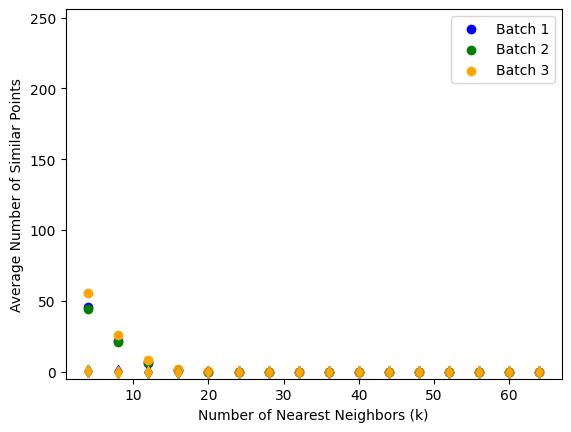

In [ ]:
import matplotlib.pyplot as plt

fig,ax=plt.subplots()
ax.set_ylim((-5,256))
ax.scatter(all_k,b1_average,label="Batch 1", color="blue")
ax.scatter(all_k,b2_average,label="Batch 2",color="green")
ax.scatter(all_k,b3_average,label="Batch 3",color="orange")
ax.scatter(all_k,b4_average,marker='d',color="blue")
ax.scatter(all_k,b5_average,marker='d',color='green')
ax.scatter(all_k,b6_average,marker='d',color="orange")
ax.set_xlabel("Number of Nearest Neighbors (k)")
ax.set_ylabel("Average Number of Similar Points")
ax.legend()

In [ ]:
fig.savefig("/content/drive/MyDrive/cpsc_533y/modelnet40_experiments/localize_figures/rot_256/average_similar_k_both.png")

In [ ]:
similar_indices

tensor([[[ 266,  910,   87,  ...,  515,  643,  719],
         [ 620,   17,  440,  ...,  554,  790,  254],
         [ 427,    1,  145,  ...,  799,  575,  208],
         ...,
         [ 462,  161,  535,  ...,  725,  898,   72],
         [1013,  913,  333,  ...,  452,   43,  200],
         [ 521,  421,  935,  ...,  781,  529,  701]],

        [[ 783,  435,  566,  ...,  743,  289,  770],
         [ 283,  250,  866,  ...,   73,  928,  956],
         [ 590,  978,   13,  ...,  319,  650,  368],
         ...,
         [ 303,  593,  803,  ...,  595,  983,  217],
         [ 542,  392,  269,  ...,  567,  860,  497],
         [ 220,  370,  194,  ...,  398,  444,  744]],

        [[  17,  636,  424,  ...,  427,  576,  950],
         [  32,  953,  546,  ...,  660,   27,  964],
         [ 913,  633,  176,  ...,  384,  359,  703],
         ...,
         [  70,  582,  765,  ...,  142,   95,  946],
         [ 396,  214,  926,  ...,  302,  144,  159],
         [ 974,  537,  278,  ...,  204,  410,  315]],

In [37]:
class MLP_ST(nn.Module):
    def __init__(self, n, use_cuda):
        super(MLP_ST, self).__init__()
        if use_cuda:
            self.device = "cuda"
        else:
            self.device = "cpu"
        self.mlp = nn.Conv2d(n, n, kernel_size=3, stride=1, padding="same")

        self.conv_1 = nn.Conv2d(n, n, kernel_size=3, stride=1, padding="same")
        self.batch_1 = nn.BatchNorm2d(n)
        self.conv_2 = nn.Conv2d(n, n, kernel_size=3, stride=1, padding="same")
        self.batch_2 = nn.BatchNorm2d(n)

        self.fc_1 = nn.Linear(n, 128)
        self.relu_1 = nn.ReLU()
        self.fc_2 = nn.Linear(128, n)

    def forward(self, x):

        # Assume b, n, k, k

        # From Section 3.3.2

        # Create local feature and feature map
        # MLP without ReLU function
        local_feature = self.mlp(x)

        feature_map = self.conv_1(local_feature.clone())
        feature_map = self.batch_1(feature_map)
        feature_map = self.conv_2(feature_map)
        feature_map = self.batch_2(feature_map)
        # print("feature_map.shape:", feature_map.shape)

        # Create soft threshold and shoft thresholding module
        b, n, m, m = feature_map.shape
        # Compress feature map into one-dimensional vector using absolute value and global average pooling
        self.global_pooling_layer = nn.AvgPool2d(m)
        X_gap = self.global_pooling_layer(torch.abs(feature_map))
        # print("X_gap.shape:", X_gap.shape)

        alphas = self.fc_1(X_gap.squeeze(-1).squeeze(-1))
        alphas = self.relu_1(alphas)
        alphas = self.fc_2(alphas)
        thresholds = alphas.unsqueeze(-1).unsqueeze(-1) * X_gap

        # Local feature activation
        # print("alphas.shape:", alphas.shape)
        # print("thresholds.shape:", thresholds.shape)
        local_feature_activation = torch.sign(feature_map) * torch.where(torch.abs(feature_map) - thresholds > 0,
                                                                           torch.abs(feature_map) - thresholds,
                                                                           0) + local_feature
        # print("local_feature_activation.shape:", local_feature_activation.shape)

        # Local feature enhancement
        X_diag = torch.diagonal(local_feature, dim1=-2, dim2=-1).to(self.device)
        # print(X_diag)
        zeros = torch.zeros((b, n, m, m)).to(self.device)
        X_diag = torch.diagonal_scatter(zeros, X_diag, dim1=-2, dim2=-1).to(self.device)

        # print(X_diag)
        # print("X_diag.shape:",X_diag.shape)
        thresholds = thresholds
        X_diag = torch.sign(X_diag) * torch.where(torch.abs(X_diag) - thresholds > 0,
                                                  torch.abs(X_diag) - thresholds,
                                                  0) + X_diag

        X_diag = X_diag.to(self.device)
        local_feature_enhanced = X_diag * local_feature_activation + torch.diagonal_scatter(local_feature_activation, torch.zeros(b, n, m), dim1=-2, dim2=-1)
        # print("local_feature_enhanced.shape:", local_feature_enhanced.shape)
        return local_feature_enhanced

In [38]:
class GlobalRepresentationNetwork(nn.Module):
    def __init__(self, config):
        super(GlobalRepresentationNetwork, self).__init__()

        self.config = config

        self.localize = config.localize
        self.descending = config.descending
        self.reduce_option = config.reduce_option

        # Need 3 MLP-ST modules
        self.mlp_1_8_points = Mlps(1, [1024], kernel_size=(3, 1), stride=1, padding="same")

        self.mlp_1 = Mlps(3, [1024], kernel_size=(3, 1), stride=1, padding="same")
        self.mlp_2 = Mlps(1024, [1024], kernel_size=1)
        self.mlp_3 = Mlps(1024, [1024])
        self.mlp_4 = Mlps(1024, [1024])

        # Need to set self.network() and self.mlp
        self.mlp_st_1 = MLP_ST(config.num_pts, config.use_cuda)
        self.mlp_st_2 = MLP_ST(config.num_pts, config.use_cuda)
        self.mlp_st_3 = MLP_ST(config.num_pts, config.use_cuda)

        self.network_channels_mlp = Mlps(1024, [1024])
        self.network_channels_mlp_st = MLP_ST(1, config.use_cuda)

    def forward(self, x, format="BNC"):

        # Obtain l, kop2, and kop3
        # Construct three gram matrixces, Nxkkx, where k is kop1, kop2, or kp3
        # optimal_k = construct_matrices(x)
        if format == "BNC":
            x = x.transpose(-2, -1)
        # print(x.shape)

        # Use 3 different k to construct 3 Gram matrices
        # k_1 = 2
        # k_2 = 4
        # k_3 = 8

        if self.config.num_pts == 8:
            knn_idx_1 = get_knn_idx(x, x, 8)
            knn_features_1 = index_points(x, knn_idx_1)
            gram_matrix_1 = compute_gram_matrix(knn_features_1.transpose(2, 1))

            sorted_gram_matrix_1 = sort_gram_matrix_rows(gram_matrix_1, descending=self.descending)
            enhanced_knn_features_1 = self.mlp_st_1(sorted_gram_matrix_1)

            if self.reduce_option == "average:":
                X_hat_j_1 = torch.mean(enhanced_knn_features_1, dim=-2)
            elif self.reduce_option == "absolute_average":
                X_hat_j_1 = torch.mean(torch.abs(enhanced_knn_features_1), dim=-2)
            else:
                X_hat_j_1, _ = torch.max(enhanced_knn_features_1, dim=-2)
            self.max_pool_1 = nn.MaxPool1d(8)
            X_hat_1 = self.max_pool_1(X_hat_j_1)
            X_concatenated = X_hat_1

        else:
            k_1 = self.config.k_1
            k_2 = self.config.k_2
            k_3 = self.config.k_3
            knn_idx_1 = get_knn_idx(x, x, k_1+1)
            knn_idx_2 = get_knn_idx(x, x, k_2+1)
            knn_idx_3 = get_knn_idx(x, x, k_3+1)
            # print(knn_idx_1.shape)
            similar_knn_idx_1, _ = get_similar(x, k_1-1, self.localize)
            similar_knn_idx_2, _ = get_similar(x, k_2-1, self.localize)
            similar_knn_idx_3, _ = get_similar(x, k_3-1, self.localize)

            knn_idx_1 = torch.concatenate((knn_idx_1, similar_knn_idx_1), dim=-1)
            knn_idx_2 = torch.concatenate((knn_idx_2, similar_knn_idx_2), dim=-1)
            knn_idx_3 = torch.concatenate((knn_idx_3, similar_knn_idx_3), dim=-1)
            # print(knn_idx_1.shape,knn_idx_2.shape,knn_idx_3.shape)
            knn_features_1 = index_points(x, knn_idx_1)
            knn_features_2 = index_points(x, knn_idx_2)
            knn_features_3 = index_points(x, knn_idx_3)

            # print("knn_features.shape:", knn_features_1.shape,knn_features_2.shape)
            # Run through MLP-ST module
            gram_matrix_1 = compute_gram_matrix(knn_features_1.transpose(2, 1))
            gram_matrix_2 = compute_gram_matrix(knn_features_2.transpose(2, 1))
            gram_matrix_3 = compute_gram_matrix(knn_features_3.transpose(2, 1))
            # print("gram_matrix_1.shape:", gram_matrix_1.shape)

            # Sort rows of the Gram matrix
            sorted_gram_matrix_1 = sort_gram_matrix_rows(gram_matrix_1, descending=self.descending)
            sorted_gram_matrix_2 = sort_gram_matrix_rows(gram_matrix_2, descending=self.descending)
            sorted_gram_matrix_3 = sort_gram_matrix_rows(gram_matrix_3, descending=self.descending)
            # print(sorted_gram_matrix_1.shape)
            enhanced_knn_features_1 = self.mlp_st_1(sorted_gram_matrix_1)
            enhanced_knn_features_2 = self.mlp_st_2(sorted_gram_matrix_2)
            enhanced_knn_features_3 = self.mlp_st_3(sorted_gram_matrix_3)
            # print("Finished enhancing")
            # Assume no have 3xNx64
            if self.reduce_option == "average":
                X_hat_j_1 = torch.mean(enhanced_knn_features_1, dim=-2)
                X_hat_j_2 = torch.mean(enhanced_knn_features_2, dim=-2)
                X_hat_j_3 = torch.mean(enhanced_knn_features_3, dim=-2)
            elif self.reduce_option == "absolute_average":
                X_hat_j_1 = torch.mean(torch.abs(enhanced_knn_features_1), dim=-2)
                X_hat_j_2 = torch.mean(torch.abs(enhanced_knn_features_2), dim=-2)
                X_hat_j_3 = torch.mean(torch.abs(enhanced_knn_features_3), dim=-2)
            elif self.reduce_option == "maximum":
                X_hat_j_1, _ = torch.max(enhanced_knn_features_1, dim=-2)
                X_hat_j_2, _ = torch.max(enhanced_knn_features_2, dim=-2)
                X_hat_j_3, _ = torch.max(enhanced_knn_features_3, dim=-2)
            # print(X_hat_j_1.shape)
            # print("Finished reducing")
            # print("X_hat_j_1.shape:", X_hat_j_1.shape)
            # Max pooling so that Nx1
            self.max_pool_1 = nn.MaxPool1d(2*k_1)
            self.max_pool_2 = nn.MaxPool1d(2*k_2)
            self.max_pool_3 = nn.MaxPool1d(2*k_3)
            X_hat_1 = self.max_pool_1(X_hat_j_1)
            X_hat_2 = self.max_pool_2(X_hat_j_2)
            X_hat_3 = self.max_pool_3(X_hat_j_3)
            # Concatenate together so that Nx3
            X_concatenated = torch.concatenate((X_hat_1, X_hat_2, X_hat_3), dim=2)
            # print("X_concatenated.shape:", X_concatenated.shape)

        # Turn to Nx1024
        if self.config.num_pts == 8:
            feature_representation = self.mlp_1_8_points(X_concatenated, format="BNC")
        else:
            feature_representation = self.mlp_1(X_concatenated, format="BNC")
        feature_representation = self.mlp_4(self.mlp_3(self.mlp_2(feature_representation, format="BNC"), format="BNC"), format="BNC")
        # print("feature_representation.shape:", feature_representation.shape)

        channels_fusion_gram_matrix = compute_gram_matrix(feature_representation.transpose(-2, -1)).unsqueeze(1)
        # print(channels_fusion_gram_matrix.shape)
        A_cf = self.network_channels_mlp(feature_representation, format="BNC")
        # print("A_cf.shape:", A_cf.shape)
        X_hat_g = A_cf * feature_representation
        # print("X_hat_g.shape:", X_hat_g.shape)
        return X_hat_g

In [39]:
# The GRN for using only k-nearest neighbors
class GlobalRepresentationNetwork_1(nn.Module):
    def __init__(self, config):
        super(GlobalRepresentationNetwork_1, self).__init__()

        self.config = config

        self.localize = config.localize
        self.descending = config.descending
        self.reduce_option = config.reduce_option

        # Need 3 MLP-ST modules
        self.mlp_1_8_points = Mlps(1, [1024], kernel_size=(3, 1), stride=1, padding="same")

        self.mlp_1 = Mlps(3, [1024], kernel_size=(3, 1), stride=1, padding="same")
        self.mlp_2 = Mlps(1024, [1024], kernel_size=1)
        self.mlp_3 = Mlps(1024, [1024])
        self.mlp_4 = Mlps(1024, [1024])

        # Need to set self.network() and self.mlp
        self.mlp_st_1 = MLP_ST(config.num_pts, config.use_cuda)
        self.mlp_st_2 = MLP_ST(config.num_pts, config.use_cuda)
        self.mlp_st_3 = MLP_ST(config.num_pts, config.use_cuda)

        self.network_channels_mlp = Mlps(1024, [1024])
        self.network_channels_mlp_st = MLP_ST(1, config.use_cuda)

    def forward(self, x, format="BNC"):

        # Obtain l, kop2, and kop3
        # Construct three gram matrixces, Nxkkx, where k is kop1, kop2, or kp3
        # optimal_k = construct_matrices(x)
        if format == "BNC":
            x = x.transpose(-2, -1)
        # print(x.shape)

        # Use 3 different k to construct 3 Gram matrices
        # k_1 = 2
        # k_2 = 4
        # k_3 = 8

        if self.config.num_pts == 8:
            knn_idx_1 = get_knn_idx(x, x, 8)
            knn_features_1 = index_points(x, knn_idx_1)
            gram_matrix_1 = compute_gram_matrix(knn_features_1.transpose(2, 1))

            sorted_gram_matrix_1 = sort_gram_matrix_rows(gram_matrix_1, descending=self.descending)
            enhanced_knn_features_1 = self.mlp_st_1(sorted_gram_matrix_1)

            if self.reduce_option == "average:":
                X_hat_j_1 = torch.mean(enhanced_knn_features_1, dim=-2)
            elif self.reduce_option == "absolute_average":
                X_hat_j_1 = torch.mean(torch.abs(enhanced_knn_features_1), dim=-2)
            else:
                X_hat_j_1, _ = torch.max(enhanced_knn_features_1, dim=-2)
            self.max_pool_1 = nn.MaxPool1d(8)
            X_hat_1 = self.max_pool_1(X_hat_j_1)
            X_concatenated = X_hat_1

        else:
            k_1 = self.config.k_1
            k_2 = self.config.k_2
            k_3 = self.config.k_3
            knn_idx_1 = get_knn_idx(x, x, k_1)
            knn_idx_2 = get_knn_idx(x, x, k_2)
            knn_idx_3 = get_knn_idx(x, x, k_3)
            # print(knn_idx_1)
            similar_knn_idx_1, _ = get_similar(x, k_1-1, self.localize)
            similar_knn_idx_2, _ = get_similar(x, k_2-1, self.localize)
            similar_knn_idx_3, _ = get_similar(x, k_3-1, self.localize)

            # knn_idx_1 = torch.concatenate((knn_idx_1, similar_knn_idx_1), dim=-1)
            # knn_idx_2 = torch.concatenate((knn_idx_2, similar_knn_idx_2), dim=-1)
            # knn_idx_3 = torch.concatenate((knn_idx_3, similar_knn_idx_3), dim=-1)
            # print(knn_idx_1.shape,knn_idx_2.shape,knn_idx_3.shape)
            knn_features_1 = index_points(x, knn_idx_1)
            knn_features_2 = index_points(x, knn_idx_2)
            knn_features_3 = index_points(x, knn_idx_3)
            # print("knn_features.shape:", knn_features_1.shape,knn_features_2.shape)
            # Run through MLP-ST module
            gram_matrix_1 = compute_gram_matrix(knn_features_1.transpose(2, 1))
            gram_matrix_2 = compute_gram_matrix(knn_features_2.transpose(2, 1))
            gram_matrix_3 = compute_gram_matrix(knn_features_3.transpose(2, 1))
            # print("gram_matrix_1.shape:", gram_matrix_1.shape)

            # Sort rows of the Gram matrix
            sorted_gram_matrix_1 = sort_gram_matrix_rows(gram_matrix_1, descending=self.descending)
            sorted_gram_matrix_2 = sort_gram_matrix_rows(gram_matrix_2, descending=self.descending)
            sorted_gram_matrix_3 = sort_gram_matrix_rows(gram_matrix_3, descending=self.descending)
            # print(sorted_gram_matrix_1.shape)
            enhanced_knn_features_1 = self.mlp_st_1(sorted_gram_matrix_1)
            enhanced_knn_features_2 = self.mlp_st_2(sorted_gram_matrix_2)
            enhanced_knn_features_3 = self.mlp_st_3(sorted_gram_matrix_3)
            # print("Finished enhancing")
            # Assume no have 3xNx64
            if self.reduce_option == "average":
                X_hat_j_1 = torch.mean(enhanced_knn_features_1, dim=-2)
                X_hat_j_2 = torch.mean(enhanced_knn_features_2, dim=-2)
                X_hat_j_3 = torch.mean(enhanced_knn_features_3, dim=-2)
            elif self.reduce_option == "absolute_average":
                X_hat_j_1 = torch.mean(torch.abs(enhanced_knn_features_1), dim=-2)
                X_hat_j_2 = torch.mean(torch.abs(enhanced_knn_features_2), dim=-2)
                X_hat_j_3 = torch.mean(torch.abs(enhanced_knn_features_3), dim=-2)
            elif self.reduce_option == "maximum":
                X_hat_j_1, _ = torch.max(enhanced_knn_features_1, dim=-2)
                X_hat_j_2, _ = torch.max(enhanced_knn_features_2, dim=-2)
                X_hat_j_3, _ = torch.max(enhanced_knn_features_3, dim=-2)
            # print(X_hat_j_1.shape)
            # print("Finished reducing")
            # print("X_hat_j_1.shape:", X_hat_j_1.shape)
            # Max pooling so that Nx1
            self.max_pool_1 = nn.MaxPool1d(k_1)
            self.max_pool_2 = nn.MaxPool1d(k_2)
            self.max_pool_3 = nn.MaxPool1d(k_3)
            X_hat_1 = self.max_pool_1(X_hat_j_1)
            X_hat_2 = self.max_pool_2(X_hat_j_2)
            X_hat_3 = self.max_pool_3(X_hat_j_3)
            # Concatenate together so that Nx3
            X_concatenated = torch.concatenate((X_hat_1, X_hat_2, X_hat_3), dim=2)
            # print("X_concatenated.shape:", X_concatenated.shape)

        # Turn to Nx1024
        if self.config.num_pts == 8:
            feature_representation = self.mlp_1_8_points(X_concatenated, format="BNC")
        else:
            feature_representation = self.mlp_1(X_concatenated, format="BNC")
        feature_representation = self.mlp_4(self.mlp_3(self.mlp_2(feature_representation, format="BNC"), format="BNC"), format="BNC")
        # print("feature_representation.shape:", feature_representation.shape)

        channels_fusion_gram_matrix = compute_gram_matrix(feature_representation.transpose(-2, -1)).unsqueeze(1)
        # print(channels_fusion_gram_matrix.shape)
        A_cf = self.network_channels_mlp(feature_representation, format="BNC")
        # print("A_cf.shape:", A_cf.shape)
        X_hat_g = A_cf * feature_representation
        # print("X_hat_g.shape:", X_hat_g.shape)
        return X_hat_g

In [40]:
grn=GlobalRepresentationNetwork(config)

In [43]:
config.use_cuda=True

In [44]:
grn(pc).shape

AttributeError: ignored

In [45]:
pc.shape

torch.Size([32, 256, 3])

# NLGAT

In [46]:
class NLGAT(nn.Module):
    def __init__(self, config):
        super(NLGAT, self).__init__()

        self.config = config

        self.GSN = GlobalStructureNetwork(config)

        self.GRN = GlobalRepresentationNetwork(config)

        n = config.num_pts
        c = config.num_classes
        self.max_pool=nn.MaxPool1d(n)
        self.fc_1 = nn.Linear(1024, 512)
        self.fc_2 = nn.Linear(512, 256)
        self.fc_3 = nn.Linear(256, c)

    def forward(self, x, format="BNC"):

        if config.mode == "GSN" or config.mode == "both":
            A_dp = self.GSN(x, format)

        if config.mode == "GRN" or config.mode == "both":
            X_hat_g = self.GRN(x, format)

        if config.mode == "both":
            X_g = A_dp * X_hat_g
        elif config.mode == "GSN":
            X_g = A_dp
        elif config.mode == "GRN":
            X_g = X_hat_g

        pooled_X_g = self.max_pool(X_g.transpose(2,1)).squeeze(-1)
        # print(f"pooled_X_g.shape: {pooled_X_g.shape}")
        logits = self.fc_3(self.fc_2(self.fc_1(pooled_X_g)))
        # print(f"logits.shape: {logits.shape}")
        return F.log_softmax(logits, dim=1)

    def get_loss(self, pred, label):
        # loss = F.nll_loss(pred, label)
        loss = torch.nn.CrossEntropyLoss(label_smoothing=config.label_smoothing)
        return loss(pred, label)

    def get_acc(self, pred, label):
        pred_choice = pred.max(dim=1)[1]
        # print(pred_choice.shape)
        # print(label.shape)
        acc = (pred_choice == label).float().mean()
        return acc

# Network

In [47]:
config

batch_size: 32
center: false
descending: false
gsn_init: null
label_smoothing: 0.2
localize: true
log_dir: logs
lr: 0.02
mode: both
normalize: true
num_classes: 40
num_epochs: 200
num_pts: 256
preprocess: false
reduce_option: average
rot: true
rot_type: SO3
use_cuda: true
use_voxel: false
weight_decay: 0.0

In [48]:
config.mode="both"

In [49]:
config.gsn_init=None

In [50]:
import os as os

In [53]:
config.num_epochs=200
config.reduce_option="average"
config.batch_size=32
config.lr=0.0001
config.betas=(0.9,0.999)
weight_decay=0
config.localize=True
config.use_cuda=True
config.k_1=8
config.k_2=16
config.k_3=24

model_dir = "/content/drive/MyDrive/cpsc_533y/random"

if not os.path.exists(model_dir):
    os.makedirs(model_dir)

config.log_dir = os.path.join(model_dir, "logs")

if not os.path.exists(config.log_dir):
    os.makedirs(config.log_dir)

model = NLGAT(config)
network = Network(model, config)

Network mode: both


In [54]:
config

batch_size: 32
betas: !!python/tuple
- 0.9
- 0.999
center: false
descending: false
gsn_init: null
k_1: 8
k_2: 16
k_3: 24
label_smoothing: 0.2
localize: true
log_dir: /content/drive/MyDrive/cpsc_533y/random/logs
lr: 0.0001
mode: both
normalize: true
num_classes: 40
num_epochs: 200
num_pts: 256
preprocess: false
reduce_option: average
rot: true
rot_type: SO3
use_cuda: true
use_voxel: false
weight_decay: 0.0

In [ ]:
network.train(trainDataLoader, testDataLoader)

Epoch:   0, loss_avg: 4.75056, val OA: 0.05024, best val OA: 0.05024
Epoch:   1, loss_avg: 4.76019, val OA: 0.04579, best val OA: 0.05024
Epoch:   2, loss_avg: 4.73498, val OA: 0.05186, best val OA: 0.05186
Epoch:   3, loss_avg: 4.75178, val OA: 0.04822, best val OA: 0.05186
Epoch:   4, loss_avg: 4.73723, val OA: 0.05024, best val OA: 0.05186
Epoch:   5, loss_avg: 4.76068, val OA: 0.04943, best val OA: 0.05186
Epoch:   6, loss_avg: 4.73893, val OA: 0.05105, best val OA: 0.05186
Epoch:   7, loss_avg: 4.72933, val OA: 0.04498, best val OA: 0.05186
Epoch:   8, loss_avg: 4.76802, val OA: 0.04781, best val OA: 0.05186
Epoch:   9, loss_avg: 4.75623, val OA: 0.04538, best val OA: 0.05186
Epoch:  10, loss_avg: 4.75731, val OA: 0.05308, best val OA: 0.05308
Epoch:  11, loss_avg: 4.74173, val OA: 0.04943, best val OA: 0.05308


KeyboardInterrupt: ignored

In [ ]:
network.plot_log()

In [55]:
network.train(batchTrainDataLoader, batchTestDataLoader)

Epoch:   0, loss_avg: 3.76687, val OA: 0.00000, best val OA: 0.00000
Epoch:   1, loss_avg: 3.20388, val OA: 0.00000, best val OA: 0.00000
Epoch:   2, loss_avg: 2.49915, val OA: 0.00000, best val OA: 0.00000
Epoch:   3, loss_avg: 2.69687, val OA: 0.00000, best val OA: 0.00000


KeyboardInterrupt: ignored

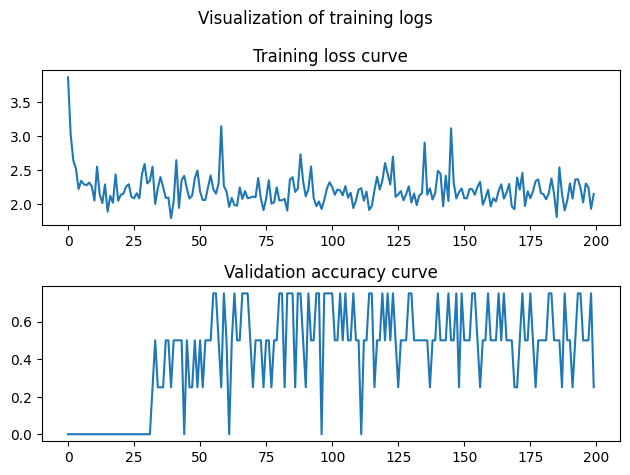

In [ ]:
fig = network.plot_log()
fig.savefig(os.path.join(model_dir,"training_logs.png"))

In [ ]:
from datetime import date
lines=["Used a single batch of size 4 for training and validation.",
       "\n"+str(config),
       str(date.today()),
       "Used label smoothing and log_softmax()",
       "Only k-nearest points with no similar points.",
       ]
with open(os.path.join(model_dir,'description.txt'), 'w') as f:
    for line in lines:
        f.write(line)
        f.write('\n')

In [ ]:
network._restore("/content/drive/MyDrive/cpsc_533y/modelnet40_experiments/so3_rot_8/single_batch_1/logs/best_model.pth",restore_training=True)

restoring /content/drive/MyDrive/cpsc_533y/modelnet40_experiments/so3_rot_8/single_batch_1/logs/best_model.pth


In [ ]:
config.noise_std=0.08
noisy_testDataset=ModelNetDataLoader(test_data,test_label,use_voxel=use_voxel,point_num=n_points,rot_type=rot_type,rot=rot,noise_std=config.noise_std)
noisy_testDataLoader=torch.utils.data.DataLoader(noisy_testDataset,batch_size=config.batch_size,shuffle=False)

In [ ]:
print(config.noise_std)
network.test(noisy_testDataLoader, mode="test")

0.08
restoring /content/drive/MyDrive/cpsc_533y/modelnet40_experiments/no_rot_8/full_train_1/logs/best_model.pth


tensor(0.0616, device='cuda:0')

In [ ]:
sum([x.nelement() for x in network.model.GSN.parameters()])

1055744

In [ ]:
sum([x.nelement() for x in network.model.GRN.parameters()])

4259235

In [52]:
import matplotlib.pyplot as plt
import os as os

class Network(object):
    def __init__(self, model, config):
        self.config = config
        self.model = model
        self.optimizer = torch.optim.Adam(
            model.parameters(), lr=config.lr, weight_decay=config.weight_decay
        )

        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=1, gamma=0.7)

        if self.config.use_cuda:
            self.model.cuda()

        # init auxiliary stuff such as log_func
        self._init_aux()
        print(f"Network mode: {config.mode}")

    def _init_aux(self):
        self.log_func = print

        self.log_dir = self.config.log_dir
        if not os.path.exists(self.log_dir):
            os.makedirs(self.log_dir)

        self.checkpts_file = os.path.join(self.log_dir, "checkpoint.pth")

        self.bestmodel_file = os.path.join(self.log_dir, "best_model.pth")

        self.train_losses = []
        self.valid_oas = []
        self.idx_steps = []

    def plot_log(self):
        fig, (ax1, ax2) = plt.subplots(2)
        fig.suptitle("Visualization of training logs")

        ax1.plot(self.idx_steps, self.train_losses)

        if self.config.use_cuda:
            valid_oas = [acc.cpu().item() for acc in self.valid_oas]
        else:
            valid_oas = self.valid_oas
        ax2.plot(self.idx_steps, valid_oas)
        ax1.set_title("Training loss curve")
        ax2.set_title("Validation accuracy curve")
        plt.tight_layout()
        plt.show()
        plt.close()
        return fig

    def _save(self, pt_file):
        torch.save(
            {
                "model": self.model.state_dict(),
                "optimizer": self.optimizer.state_dict(),
                "train_losses": self.train_losses,
                "valid_oas": self.valid_oas,
                "idx_steps": self.idx_steps,
                "config": self.config,
            },
            pt_file,
        )

    def _restore(self, pt_file, restore_training=False):
        print(f"restoring {pt_file}")

        load_res = torch.load(pt_file)
        self.model.load_state_dict(load_res["model"])
        self.optimizer.load_state_dict(load_res["optimizer"])

        if restore_training:
            self.train_losses = load_res["train_losses"]
            self.valid_oas = load_res["valid_oas"]
            self.idx_steps = load_res["idx_steps"]

    def train(self, loader_tr, loader_va):
        self.model.train()
        best_va_acc = 0

        for epoch in range(self.config.num_epochs):
            losses = []
            for data in loader_tr:
                if self.config.use_cuda:
                    for i in range(0, len(data)):
                        data[i] = data[i].cuda()

                labels = data[2].squeeze(-1)
                one_hot_labels = torch.nn.functional.one_hot(labels.type(torch.int64), config.num_classes)
                # print(data[2].shape)
                pred = self.model(data[0])

                loss = self.model.get_loss(pred, one_hot_labels.type(torch.float64))
                losses += [loss]

                loss.backward()

                self.optimizer.step()
                self.scheduler.step()
                self.optimizer.zero_grad()

            loss_avg = torch.mean(torch.stack(losses)).item()

            # Save model every epoch.
            self._save(self.checkpts_file)
            acc = self.test(loader_va, mode="valid")
            if acc > best_va_acc:
                best_va_acc = acc
                self._save(self.bestmodel_file)

            self.log_func(
                "Epoch: %3d, loss_avg: %.5f, val OA: %.5f, best val OA: %.5f"
                %(epoch, loss_avg, acc, best_va_acc)
            )

            # Recording training losses and validation performance.
            self.train_losses += [loss_avg]
            self.valid_oas += [acc]
            self.idx_steps += [epoch]

    def test(self, loader_te, mode="test"):
        if mode == "test":
            self._restore(self.bestmodel_file)
        self.model.eval()

        with torch.no_grad():
            accs = []
            num_samples = 0
            for data in loader_te:
                if self.config.use_cuda:
                    for i in range(0, len(data)):
                        data[i] = data[i].cuda()
                batch_size = len(data[2])
                pred = self.model(data[0])
                acc = self.model.get_acc(pred, data[2].squeeze(-1))
                accs += [acc * batch_size]
                # print(accs)
                num_samples += batch_size
            # print(accs)
            # print(num_samples)
            avg_acc = torch.stack(accs).sum() / num_samples

        self.model.train()
        return avg_acc

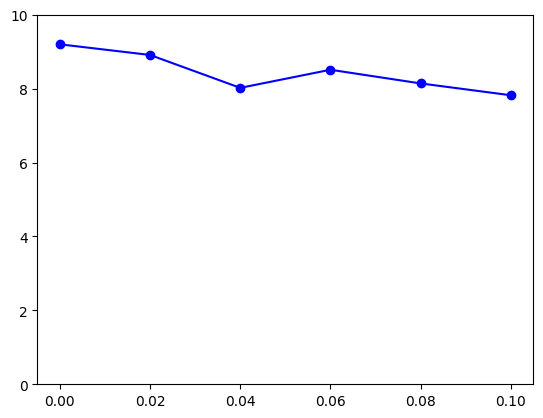

In [ ]:
import matplotlib.pyplot as plt

fig,ax=plt.subplots()
ax.set_ylim(([0,10]))
ax.plot([0.0,0.02,0.04,0.06,0.08,0.10],[9.198,8.91,8.02,8.51,8.14,7.82],marker="o",color="blue")
ax.plot([0.0,0.02,0.04,0.06,0.08,0.10],[])
# ax.legend()
fig.savefig("/content/drive/MyDrive/cpsc_533y/modelnet40_experiments/no_rot_64/full_train_1/noise_accuracy.png")

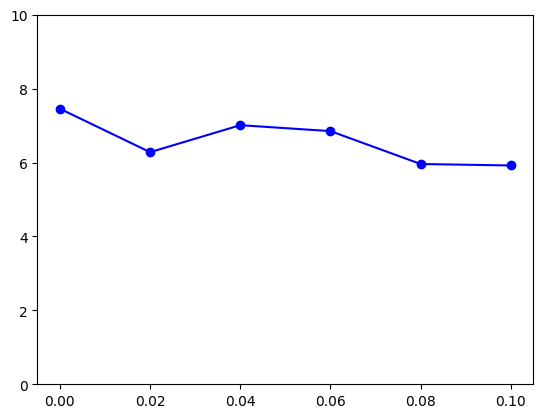

In [ ]:
import matplotlib.pyplot as plt

fig,ax=plt.subplots()
ax.set_ylim(([0,10]))
ax.plot([0.0,0.02,0.04,0.06,0.08,0.10],[7.455,6.28,7.01,6.85,5.96,5.92],marker="o",color="blue")
# ax.legend()
fig.savefig("/content/drive/MyDrive/cpsc_533y/modelnet40_experiments/no_rot_16/full_train_1/noise_accuracy.png")

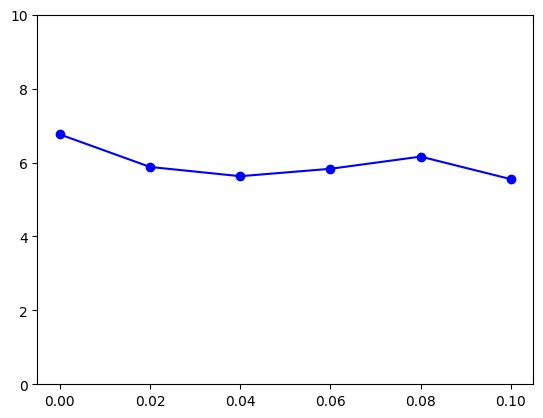

In [ ]:
import matplotlib.pyplot as plt

fig,ax=plt.subplots()
ax.set_ylim(([0,10]))
ax.plot([0.0,0.02,0.04,0.06,0.08,0.10],[6.76,5.88,5.63,5.83,6.16,5.55],marker="o",color="blue")
# ax.legend()
fig.savefig("/content/drive/MyDrive/cpsc_533y/modelnet40_experiments/no_rot_8/full_train_1/noise_accuracy.png")

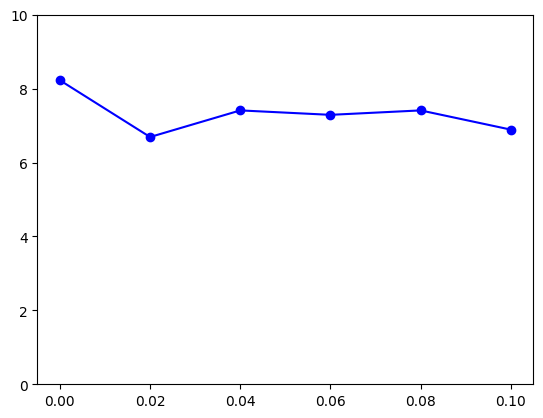

In [ ]:
import matplotlib.pyplot as plt

fig,ax=plt.subplots()
ax.set_ylim(([0,10]))
ax.plot([0.0,0.02,0.04,0.06,0.08,0.10],[8.225,6.69,7.41,7.29,7.41,6.89],marker="o",color="blue")
# ax.legend()
fig.savefig("/content/drive/MyDrive/cpsc_533y/modelnet40_experiments/no_rot_256/full_train_3/noise_accuracy.png")